<a href="https://colab.research.google.com/github/ladrianx/proyectos/blob/main/nn_retro_stf_p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red Neuronal + Propagación usando *R*

## Instalar paquetes necesarios, descargar datos, calcular rendimientos y graficarlos

[1] "GMEXICOB.MX"

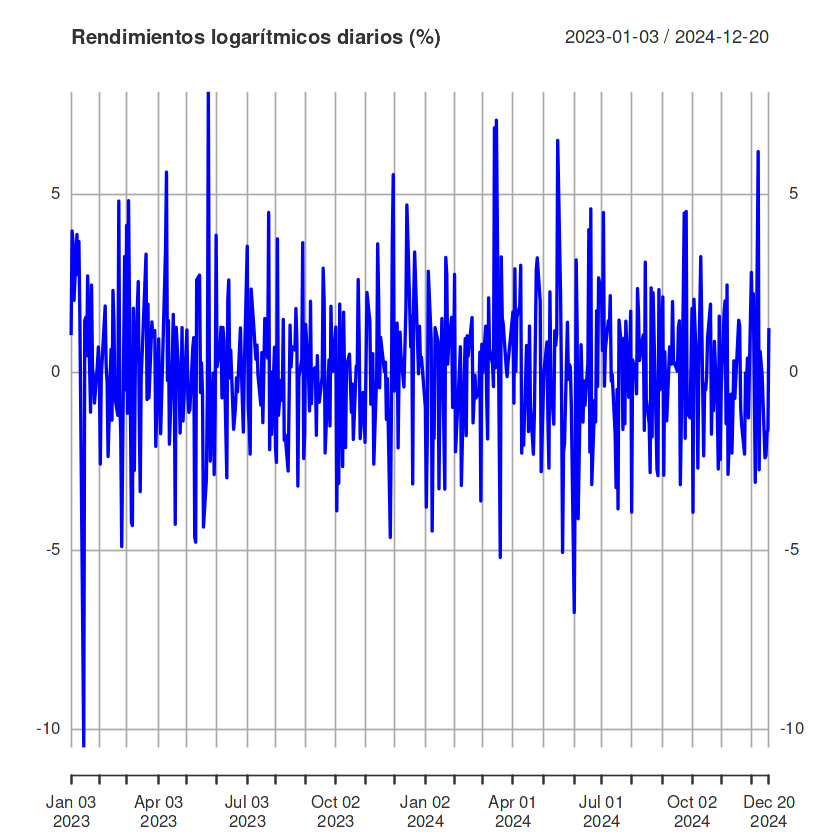

In [ ]:
# Verificar e instalar el paquete necesario
if (!requireNamespace("quantmod", quietly = TRUE)) {
  install.packages("quantmod")
}
library(quantmod)

# Descargar datos de Yahoo Finance
symbol <- "GMEXICOB.MX"  # Grupo México
start_date <- "2023-01-01"
end_date <- "2024-12-22"

# Obtener datos
getSymbols(symbol, src = "yahoo", from = start_date, to = end_date)

# Calcular rendimientos porcentuales diarios
data <- get(symbol)
returns <- na.omit(diff(log(Cl(data))))  # Rendimientos logarítmicos
returns_porcentajes <- returns*100

# Visualización de los rendimientos
plot(returns_porcentajes, main = "Rendimientos logarítmicos diarios (%)", col = "blue", type = "l")

## Cálculo de ACF y *lag* más significativo

El lag con mayor valor absoluto es: 3 con un valor de: -0.08012288 
El lag más significativo es: 3 


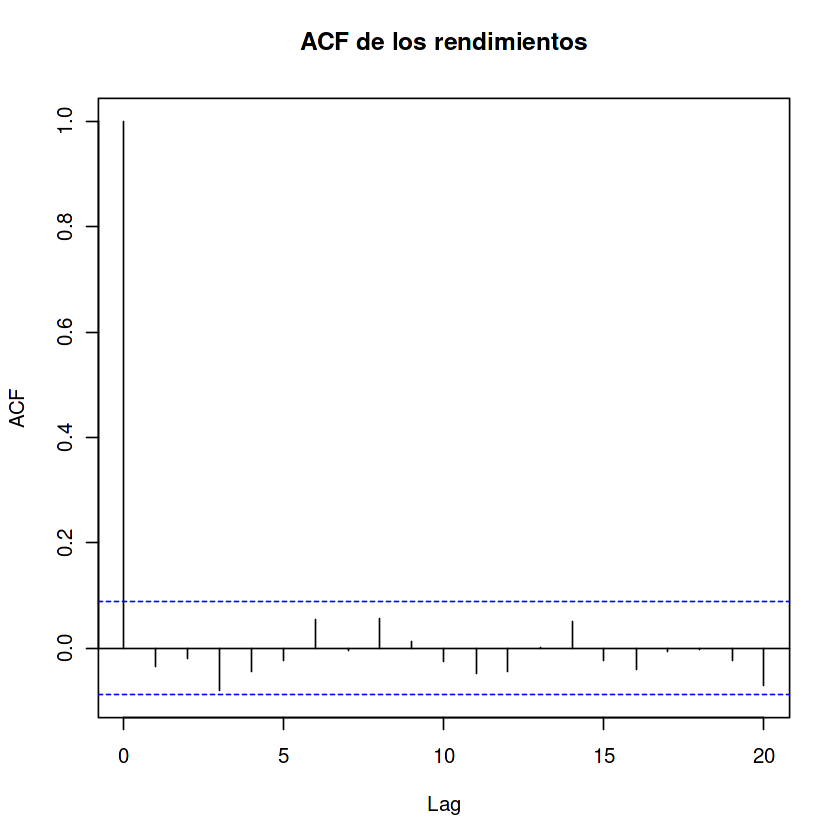

In [ ]:
# Calcular la función de autocorrelación (ACF)
acf_result <- acf(returns, lag.max = 20, plot = TRUE, main = "ACF de los rendimientos")

# Identificar el lag más significativo
lags <- acf_result$lag[-1]  # Excluir el lag 0
acf_values <- acf_result$acf[-1]
max_abs_lag <- which.max(abs(acf_values))
lag_significant <- if (length(lags) > 0) lags[max_abs_lag] else 5

# Mostrar el resultado
cat("El lag con mayor valor absoluto es:", lags[max_abs_lag],
    "con un valor de:", acf_values[max_abs_lag], "\n")

cat("El lag más significativo es:", lag_significant, "\n")

## Separación de datos y normalización

In [ ]:
# Crear una función para generar datos laggeados
generate_lagged_data <- function(returns, lag) {
  n <- length(returns)
  data_matrix <- matrix(NA, nrow = n - lag, ncol = lag + 1)

  for (i in 1:(n - lag)) {
    data_matrix[i, ] <- returns[i:(i + lag)]
  }

  colnames(data_matrix) <- c(paste0("Lag_", 1:lag), "Target")
  return(as.data.frame(data_matrix))
}

# Generar datos laggeados
lag <- as.integer(lag_significant)
lagged_data <- generate_lagged_data(returns, lag)

# Separar el último día para evaluación final (último registro de los datos)
final_test <- lagged_data[nrow(lagged_data), , drop = FALSE]
lagged_data <- lagged_data[-nrow(lagged_data), ]

# Dividir los datos restantes en entrenamiento y validación
set.seed(42)
train_ratio <- 0.8
train_size <- floor(train_ratio * nrow(lagged_data))
train_data <- lagged_data[1:train_size, ]
validation_data <- lagged_data[(train_size + 1):nrow(lagged_data), ]

# Normalización (aplicar solo a datos de entrenamiento y validación)
normalize <- function(x) {
  range <- max(x) - min(x)
  if (range == 0) return(rep(0.5, length(x)))  # Evitar divisiones por cero
  (x - min(x)) / range
}

train_data_normalized <- as.data.frame(lapply(train_data, normalize))
validation_data_normalized <- as.data.frame(lapply(validation_data, normalize))

# Función para invertir la normalización (Min-Max)
invert_normalization <- function(normalized_data, original_data) {
  min_val <- min(original_data)
  max_val <- max(original_data)
  return(normalized_data * (max_val - min_val) + min_val)
}

## Modelo

In [ ]:
# Función de activación sigmoide
sigmoid <- function(x) {
  1 / (1 + exp(-x))
}

# Derivada de la función sigmoide
sigmoid_derivative <- function(x) {
  x * (1 - x)
}

# Inicialización de pesos aleatorios
initialize_weights <- function(input_size, hidden_size, output_size) {
  list(
    W1 = matrix(runif(input_size * hidden_size, -0.5, 0.5), nrow = input_size, ncol = hidden_size),
    b1 = runif(hidden_size, -0.5, 0.5),
    W2 = matrix(runif(hidden_size * output_size, -0.5, 0.5), nrow = hidden_size, ncol = output_size),
    b2 = runif(output_size, -0.5, 0.5)
  )
}

# Propagación hacia adelante
forward_propagation <- function(X, weights) {
  Z1 <- X %*% weights$W1 + weights$b1
  A1 <- sigmoid(Z1)
  Z2 <- A1 %*% weights$W2 + weights$b2
  A2 <- Z2
  list(A1 = A1, A2 = A2)
}

# Retropropagación
backward_propagation <- function(X, Y, cache, weights, learning_rate) {
  m <- nrow(X)
  dZ2 <- cache$A2 - Y
  dW2 <- t(cache$A1) %*% dZ2 / m
  db2 <- colSums(dZ2) / m
  dA1 <- dZ2 %*% t(weights$W2)
  dZ1 <- dA1 * sigmoid_derivative(cache$A1)
  dW1 <- t(X) %*% dZ1 / m
  db1 <- colSums(dZ1) / m

  weights$W1 <- weights$W1 - learning_rate * dW1
  weights$b1 <- weights$b1 - learning_rate * db1
  weights$W2 <- weights$W2 - learning_rate * dW2
  weights$b2 <- weights$b2 - learning_rate * db2

  return(weights)
}

# Entrenamiento del modelo
train_mlp <- function(X, Y, input_size, hidden_size, output_size, epochs, learning_rate) {
  weights <- initialize_weights(input_size, hidden_size, output_size)

  mse_train <- numeric(epochs)
  mse_val <- numeric(epochs)

  for (epoch in 1:epochs) {
    # Entrenamiento
    cache_train <- forward_propagation(X, weights)
    mse_train[epoch] <- mean((cache_train$A2 - Y)^2)

    # Validación
    X_val <- as.matrix(validation_data_normalized[, -ncol(validation_data_normalized)])
    Y_val <- as.matrix(validation_data_normalized[, ncol(validation_data_normalized)])
    cache_val <- forward_propagation(X_val, weights)
    mse_val[epoch] <- mean((cache_val$A2 - Y_val)^2)

    # Retropropagación
    weights <- backward_propagation(X, Y, cache_train, weights, learning_rate)

    if (epoch %% 100 == 0) {
      cat("Época:", epoch, "MSE Entrenamiento:", mse_train[epoch], "MSE Validación:", mse_val[epoch], "\n")
    }
  }

  # Graficar los errores de entrenamiento y validación
  plot(1:epochs, mse_train, type = "l", col = "blue", ylim = range(c(mse_train, mse_val)), xlab = "Época", ylab = "MSE", main = "Errores de Entrenamiento y Validación")
  lines(1:epochs, mse_val, col = "red")
  legend("topleft", legend = c("Entrenamiento", "Validación"), col = c("blue", "red"), lty = 1)

  return(weights)
}

## Entrenamiento y evalución.

Época: 100 MSE Entrenamiento: 0.03957047 MSE Validación: 0.04431936 
Época: 200 MSE Entrenamiento: 0.02480773 MSE Validación: 0.06928838 
Época: 300 MSE Entrenamiento: 0.02388363 MSE Validación: 0.07741112 
Época: 400 MSE Entrenamiento: 0.02366217 MSE Validación: 0.07929885 
Época: 500 MSE Entrenamiento: 0.02347806 MSE Validación: 0.07967126 
Época: 600 MSE Entrenamiento: 0.02329843 MSE Validación: 0.07970005 
Época: 700 MSE Entrenamiento: 0.0231217 MSE Validación: 0.07965258 
Época: 800 MSE Entrenamiento: 0.02294779 MSE Validación: 0.07958884 
Época: 900 MSE Entrenamiento: 0.02277668 MSE Validación: 0.07952225 
Época: 1000 MSE Entrenamiento: 0.02260835 MSE Validación: 0.0794558 
Valor real del último dato: 1.249441 
Predicción del último dato: 1.001591 
Error absoluto del último dato: 0.2478498 
MSE del último dato: 0.06142954 


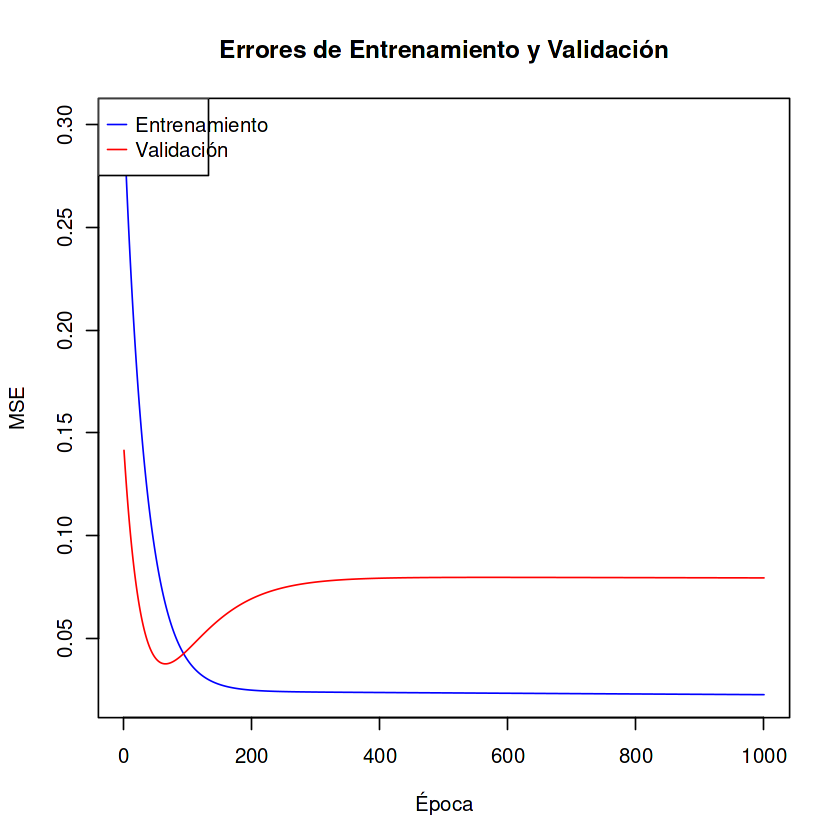

In [ ]:
# Entrenar el modelo
X_train <- as.matrix(train_data_normalized[, -ncol(train_data_normalized)])
Y_train <- as.matrix(train_data_normalized[, ncol(train_data_normalized)])

input_size <- lag
hidden_size <- lag - 1
output_size <- 1
epochs <- 1000
learning_rate <- 0.01

weights <- train_mlp(X_train, Y_train, input_size, hidden_size, output_size, epochs, learning_rate)

# Evaluar el último dato (final_test) sin normalizar
X_final_test <- as.matrix(final_test[, -ncol(final_test)])
Y_final_test <- final_test[, ncol(final_test)]

cache_final_test <- forward_propagation(X_final_test, weights)
Y_pred_final <- cache_final_test$A2

# Invertir la normalización de la predicción final
Y_pred_final_inverted <- invert_normalization(Y_pred_final, lagged_data$Target)

# Cálculo de errores para los datos invertidos
mse_final <- (((Y_pred_final_inverted - Y_final_test)*100)^2)
abs_error_final <- abs(Y_pred_final_inverted - Y_final_test)*100

cat("Valor real del último dato:", Y_final_test*100, "\n")
cat("Predicción del último dato:", Y_pred_final_inverted*100, "\n")
cat("Error absoluto del último dato:", abs_error_final, "\n")
cat("MSE del último dato:", mse_final, "\n")